# RL Bandit Notebook

In [1]:
# Notebook for RL Work
# Written By Bryan

# ==== Bandit Imports ====
from Bandits import *    # Custom bandit classes

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize



# ==== Mermaid display imports ====
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## eGreedy 

#### Trial Configurations

Testbed Means: [-1.535292787749723, 0.48144694019327605, -0.41280934797332614, -0.7198476135036375, -0.555805435656865, -0.6032304783317902, 0.509555009923398, -1.8264711164515182, -0.08906501780431478, 0.6525269926596511]


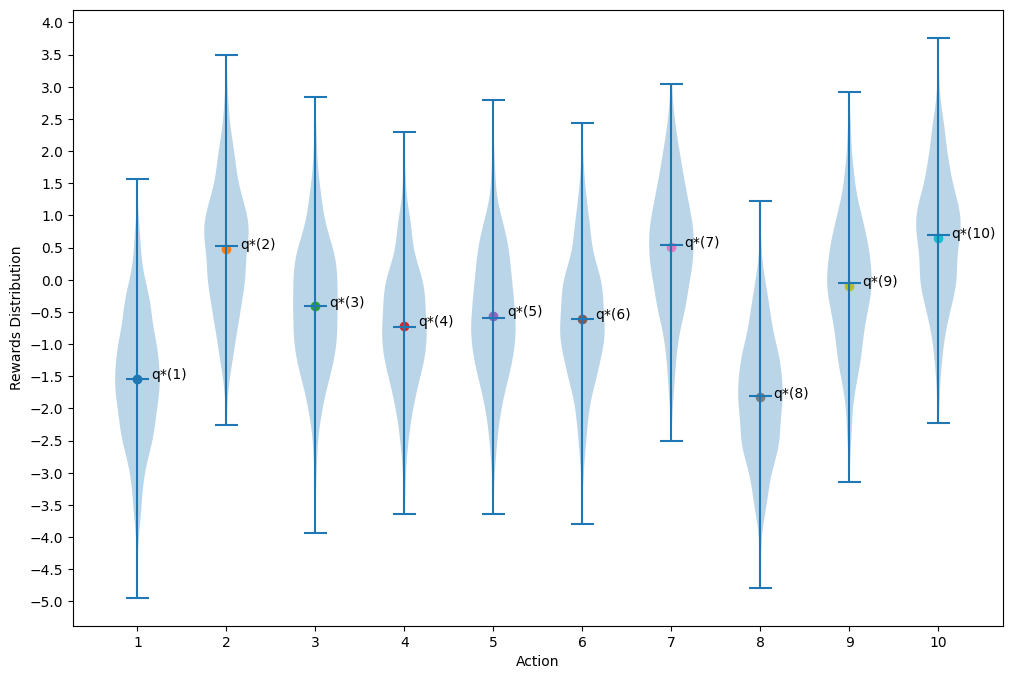

In [2]:
# Create and Show env
env = Testbed(num_problems=1000)

#Trial Params
k = env.k
steps = 100
trial_params = [k, steps]
reward_values = env.q_star

env.show_mean()
env.show_testbed()      # NOTE: Displays what the reward distribution could look like
# print(env.arms)

In [3]:
#Model Params
start_val = 1


# Create eGreedy task
eg_01 = create_bandit_task(model_type="EG", model_params=[0,0.1], trial_params=trial_params, reward_values=reward_values, start_val=start_val)

tasks = [eg_01]
for task in tasks:
    task.simulate()


100%|██████████| 1000/1000 [00:00<00:00, 1330.42it/s]


## Softmax

In [4]:
#Model Params
model_type = "SM"
alpha = 0.6
temp = 10                       # inverse temp
model_params = [alpha, temp]
start_val = 1



SM = create_bandit_task(model_type, model_params, trial_params, reward_values, start_val)
SM.simulate()

100%|██████████| 1000/1000 [00:00<00:00, 1416.16it/s]


## Softmax_UCB

In [5]:
# Model Params
model_type = "SMUCB"
alpha = 0.1
temp = 5
uncertParam = .2
#uncert = 2
model_params = [alpha, temp, uncertParam]
start_val = 1

SMUCB = create_bandit_task(model_type=model_type, model_params=model_params, trial_params=trial_params, reward_values=reward_values, start_val=start_val)

SMUCB.simulate()

100%|██████████| 1000/1000 [00:03<00:00, 291.01it/s]


### Simulate Performance

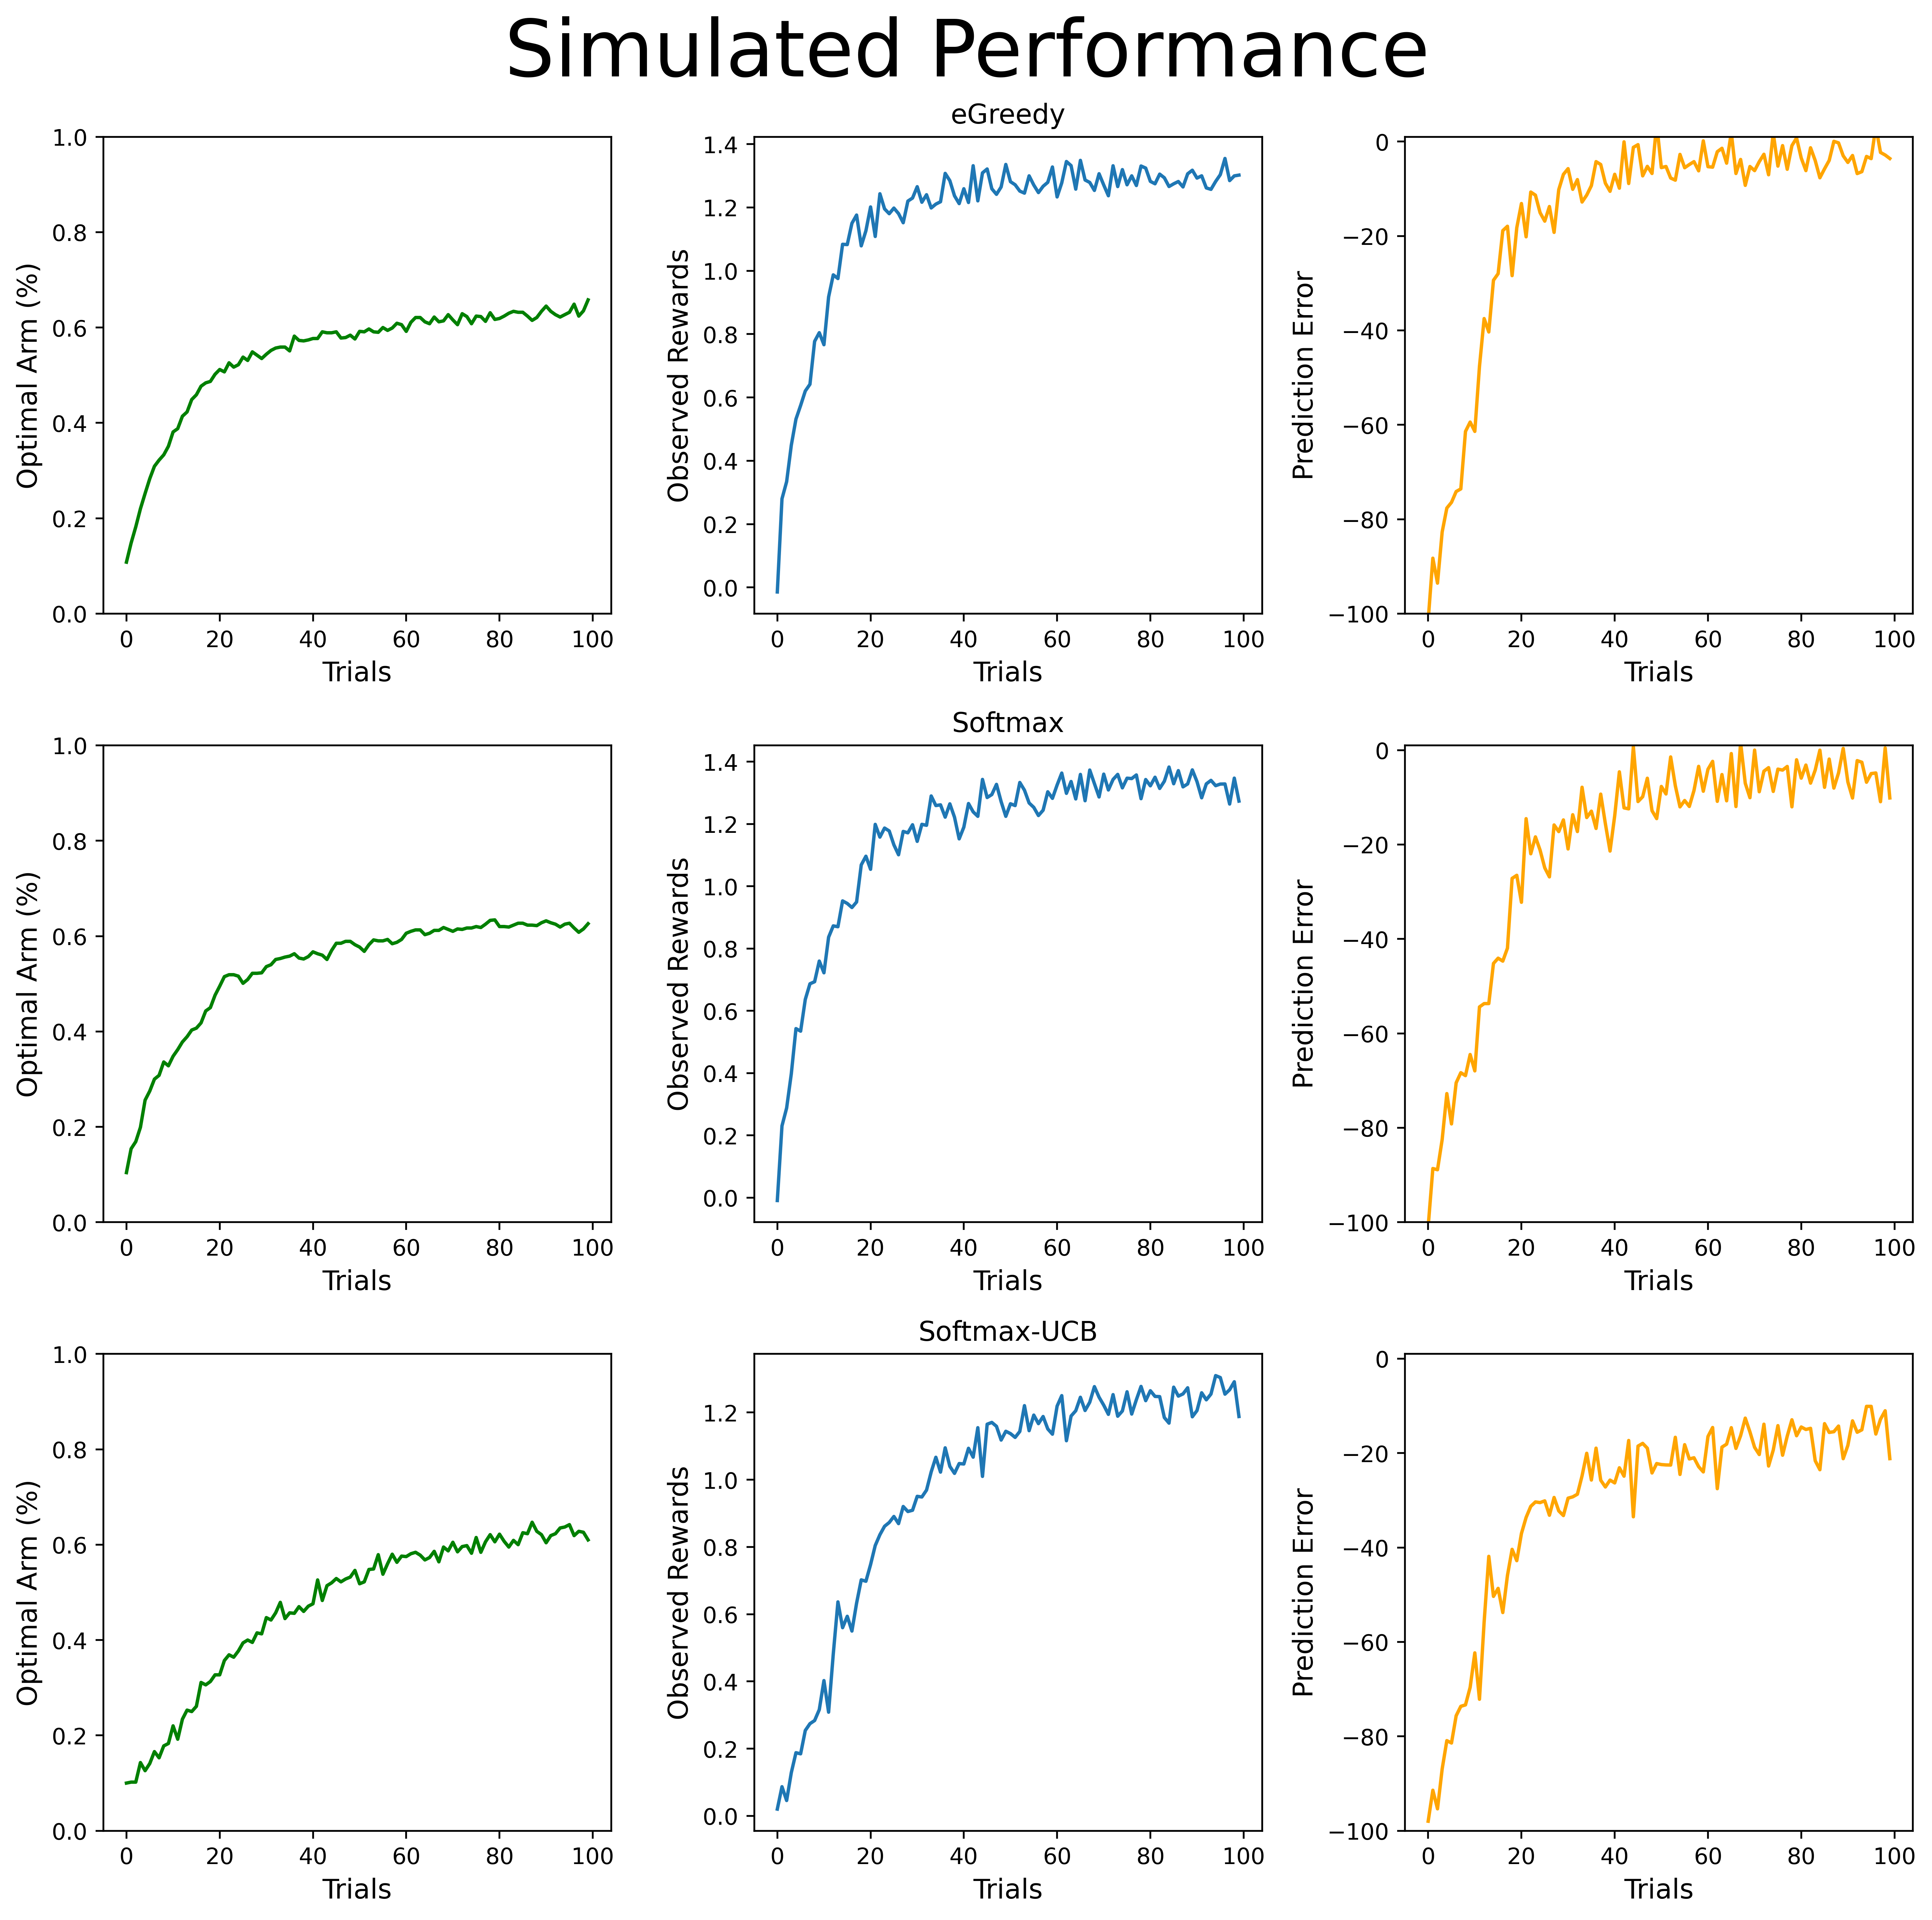

In [6]:
model_performance_summary(bandits=[eg_01, SM, SMUCB])
# print(f"Param Name:{key}\n {value}" for key, value in vars(eg_01))

## Log-Likelihood

In [7]:
eg_01.simulate_LL()
print(eg_01.total_LL_array)


100%|██████████| 1000/1000 [00:00<00:00, 5862.22it/s]

[436.79761957 436.79761957 432.40317041 441.19206872 449.98096703
 441.19206872 441.19206872 445.58651788 432.40317041 445.58651788
 436.79761957 449.98096703 441.19206872 436.79761957 111.60838212
 432.40317041 445.58651788 436.79761957 445.58651788 432.40317041
 406.03647549 445.58651788 445.58651788 445.58651788 441.19206872
 432.40317041 428.00872126 445.58651788 397.24757718 449.98096703
 445.58651788 445.58651788 423.6142721  441.19206872 449.98096703
 436.79761957 441.19206872 436.79761957 392.85312802 436.79761957
 441.19206872 441.19206872 441.19206872 445.58651788 436.79761957
 445.58651788 436.79761957 445.58651788 441.19206872 449.98096703
 445.58651788 441.19206872 445.58651788 449.98096703 401.64202633
 428.00872126 441.19206872 445.58651788 445.58651788 436.79761957
 441.19206872 445.58651788 445.58651788 436.79761957 445.58651788
 445.58651788 449.98096703 445.58651788 449.98096703  89.63613635
 441.19206872 441.19206872 445.58651788 449.98096703 129.18617874
 432.40317

## Model Validation

#### Param Recovery
Fit data to model it was simulated with
<ol>
<li>Simulate choices and rewards using chosen parameter values(acts as ground truth)</li>
<li>
Run fitting procedure (neg log likelihood function) on simulated choice AND reward data.
See if we an estimate simulated parameter values (estimates are fitted parameter values)
</li>
</ol>

In [8]:
# Run this to display mermaid flowchart of parameter recovery
mm("""
flowchart LR
   subgraph input-parameters
   direction TB
   id1([epsilon])
   id2([alpha])
   id3([etc...])
   id1 ~~~ id2 ~~~ id3
   end

   subgraph output-parameters
   direction TB
   id4([epsilon])
   id5([alpha])
   id6([etc...])
   id4 ~~~ id5 ~~~ id6
   end

   simData[(Simulated Data)]
   model((RL Model))
   n([noise])
   fm{{fit data to model}}

   input-parameters --"(1) input"--> model
   model --"(1) creates"--> simData
   simData -."(2) (optional) Add".-> n
   simData --> fm
   n -.-> fm
   fm ~~~ output-parameters
   fm --"(3) Outputs"--> output-parameters
   input-parameters o-- "(4) compare"  --o output-parameters

""")

In [9]:
num_models = 2      # number of models
num_sims = 30       # number of agents to fit
num_trials = 0      #

reward_modelPR = np.zeros(shape=[num_models, num_sims, num_trials])
choices_modelPR = np.zeros(shape=[num_models, num_sims, num_trials])

# Create Parameters
paraSimPR = paramCreate(num_sims)

# 
paraFitPR = np.zeros(shape=[num_sims, num_Param])
LLArray = np.zeros(shape=[num_sims, num_models])

# number of fitting attempts
num_fit_attempts = 5

for agent in tqdm(range(num_sims)):
    
    # generate environment (non stationary bandit environment from Daw et al in TF Doc)
    environment = Testbed() 

    # eGreedy
    EG = SimpleBandit(arms=10, epsilon=paraSimPR[agent, 0:2], steps=1000, q_star=environment.q_star, initial_Q=0.1)
    EG.simulate()

    # Softmax
    SM = SimpleBandit(arms=10, epsilon=paraSimPR[agent, 2:4], steps=1000, q_star=environment.q_star, initial_Q=0, argmax_func=softmax)
    SM.simulate()
    # Softmax UCB (Softmax Distrubutrion with upper confidence bound action selection)
    #SMUCB_Choice = SimpleBandit(arms=10, epsilon=paraSimPR[param_count, 4:7], steps=1000, q_star=reward_values.q_star, initial_Q=0, argmax_func=UCB)



NameError: name 'num_Param' is not defined

#### Model Recovery

Fit data to all models
<ol>
<li>
Use simulated choice and reward data from paramater recovery step
</li>

<li>
Calculate negative log likelihood values using each model on the simulated data
</li>
</ol>
